# 파이토치 사전훈련 모델 사용
- `torchvision`의 `models`를 활용하여 전이학습

- https://pytorch.org/docs/stable/torchvision/models.html

- 코드 출처: https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

<br>

<br>

## modules import

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import time
import os
import copy

<br>

<br>

## GPU 설정

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


<br>

<br>

## 데이터 로드 및 확인

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data -d .

<br>

<br>

## 전처리 설정

<br>

#### `torchvision.transforms.RandomReizedCrop()`
#### `torchvision.transforms.RandomHorizontalFlip()`

In [5]:
data_transforms = {'train': transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                   'val': transforms.Compose([transforms.RandomResizedCrop(256),
                                              transforms.RandomHorizontalFlip(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [21]:
data_dir = './hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                         data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: DataLoader(image_datasets[x],
                            batch_size=4,
                            shuffle=True,
                            num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [22]:
print(class_names)

['ants', 'bees']


<br>

<br>

## 사전훈련된 모델 로드

<br>

#### `torchvisions.models.resnet18(pretrained)`

In [23]:
model_ft = models.resnet18(pretrained=True)

<br>

- ImageNet 의 데이터를 훈련한 모델
  - `num_class`가 1000

In [24]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 

<br>

- 데이터의 클래스 수에 맞게 `out_features` 변경

In [25]:
print(model_ft.fc)
print(model_ft.fc.in_features)

Linear(in_features=512, out_features=1000, bias=True)
512


In [26]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

<br>

<br>

## 손실함수와 옵티마이저

In [27]:
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

<br>

#### `torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)`

<br>

-  7 에폭마다 0.1씩 학습율 감소

In [28]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

<br>

<br>

## 모델 학습

<br>

- 학습 함수 정의

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}\t{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print('{} Loss: {:.4f}\tAcc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best Validation Acc: {:4f}'.format(best_acc))
  
  model.load_state_dict(best_model_wts)
  return model

In [36]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0	24
----------
train Loss: 0.4924	Acc: 0.8279
val Loss: 0.4139	Acc: 0.7974

Epoch 1	24
----------
train Loss: 0.5667	Acc: 0.7582
val Loss: 0.5256	Acc: 0.8170

Epoch 2	24
----------
train Loss: 0.5773	Acc: 0.7992
val Loss: 0.4272	Acc: 0.8431

Epoch 3	24
----------
train Loss: 0.4457	Acc: 0.8361
val Loss: 0.2584	Acc: 0.8824

Epoch 4	24
----------
train Loss: 0.3416	Acc: 0.8730
val Loss: 0.3813	Acc: 0.8562

Epoch 5	24
----------
train Loss: 0.3102	Acc: 0.8689
val Loss: 0.2772	Acc: 0.8824

Epoch 6	24
----------
train Loss: 0.2787	Acc: 0.8811
val Loss: 0.2699	Acc: 0.9085

Epoch 7	24
----------
train Loss: 0.3967	Acc: 0.8238
val Loss: 0.2690	Acc: 0.8954

Epoch 8	24
----------
train Loss: 0.3317	Acc: 0.8484
val Loss: 0.2658	Acc: 0.8954

Epoch 9	24
----------
train Loss: 0.2931	Acc: 0.8648
val Loss: 0.2321	Acc: 0.9150

Epoch 10	24
----------
train Loss: 0.3103	Acc: 0.8811
val Loss: 0.2212	Acc: 0.9216

Epoch 11	24
----------
train Loss: 0.2639	Acc: 0.8852
val Loss: 0.2405	Acc: 0.9150

Ep

<br>

<br>

## 결과 시각화

<br>

- 시각화 함수 정의

In [37]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  fig = plt.figure(figsize=(10, 5))
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [45]:
def visualize_model(model, num_images=2):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(model=was_training)
          return

    model.train(model=was_training)

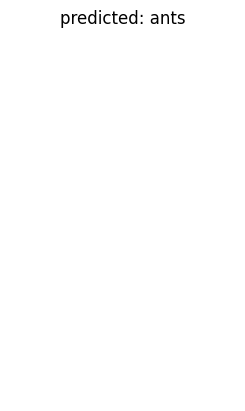

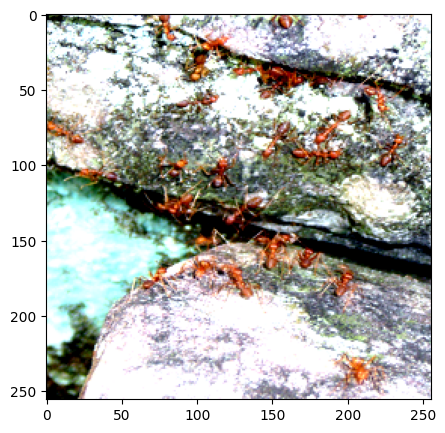

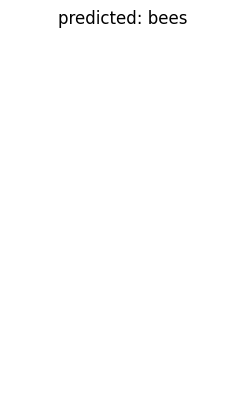

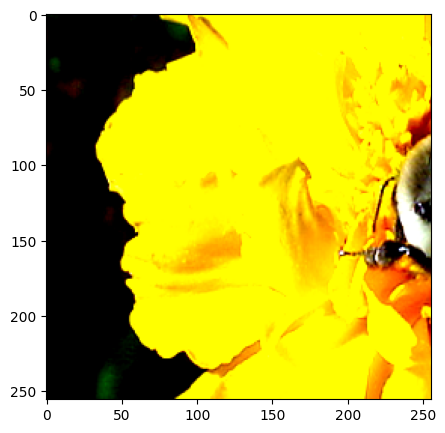

TypeError: ignored

In [46]:
visualize_model(model_ft)

<br>

<br>

## 고정된 특징 추출기로써의 합성곱 신경망
- **마지막 계층을 제외한 신경망의 모든 부분을 고정**

- `requires_grad == False` 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.



In [47]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [50]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0	24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 0.6411	Acc: 0.6270
val Loss: 0.2957	Acc: 0.8758

Epoch 1	24
----------
train Loss: 0.5328	Acc: 0.7705
val Loss: 0.2917	Acc: 0.8431

Epoch 2	24
----------
train Loss: 0.6782	Acc: 0.7172
val Loss: 0.1968	Acc: 0.9412

Epoch 3	24
----------
train Loss: 0.4557	Acc: 0.8238
val Loss: 0.2201	Acc: 0.9216

Epoch 4	24
----------
train Loss: 0.5076	Acc: 0.7664
val Loss: 0.2021	Acc: 0.9085

Epoch 5	24
----------
train Loss: 0.7761	Acc: 0.7090
val Loss: 0.3752	Acc: 0.8562

Epoch 6	24
----------
train Loss: 0.5509	Acc: 0.8074
val Loss: 0.1615	Acc: 0.9477

Epoch 7	24
----------
train Loss: 0.3569	Acc: 0.8648
val Loss: 0.2163	Acc: 0.9346

Epoch 8	24
----------
train Loss: 0.3824	Acc: 0.8402
val Loss: 0.2760	Acc: 0.8954

Epoch 9	24
----------
train Loss: 0.2660	Acc: 0.8975
val Loss: 0.1837	Acc: 0.9412

Epoch 10	24
----------
train Loss: 0.3114	Acc: 0.8566
val Loss: 0.2707	Acc: 0.8824

Epoch 11	24
----------
train Loss: 0.3928	Acc: 0.8197
val Loss: 0.1927	Acc: 0.9346

Epoch 12	24
----------
t

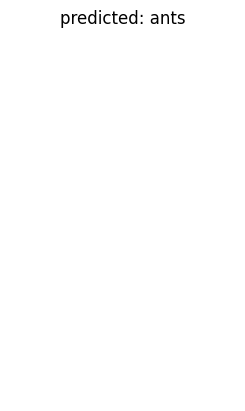

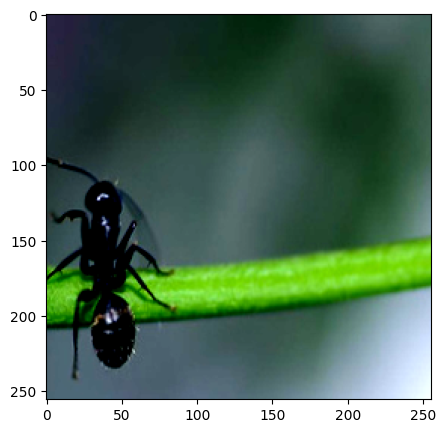

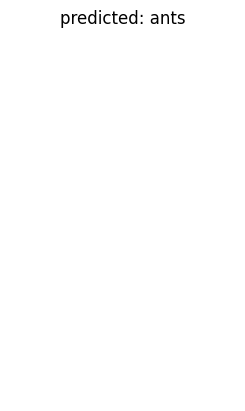

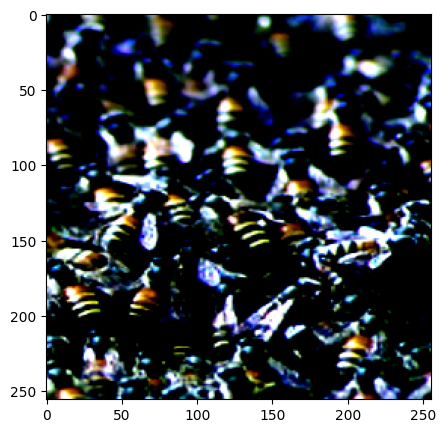

TypeError: ignored

In [51]:
visualize_model(model_conv)